# Black Friday Sales Analysis and Prediction

The dataset used in this analysis contains information of transactions in a store on Black Friday, including customers' demographical features and transaction details. The dataset comes from a competition hosted by Analytics Vidhya.

In this analysis I will do two things. Firstly I will explore the data and find some correlations between differents elements, so I can get some insights for future marketing strategies. On top of that I will also use regression method to predict future purchase. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Let's take a look at the dataset and do some data cleaning first.

In [2]:
data = pd.read_csv("/home/eva/Desktop/data/profile/black_friday/BlackFriday.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB
None


In [3]:
print(data.head(10))

   User_ID Product_ID Gender    Age  Occupation City_Category  \
0  1000001  P00069042      F   0-17          10             A   
1  1000001  P00248942      F   0-17          10             A   
2  1000001  P00087842      F   0-17          10             A   
3  1000001  P00085442      F   0-17          10             A   
4  1000002  P00285442      M    55+          16             C   
5  1000003  P00193542      M  26-35          15             A   
6  1000004  P00184942      M  46-50           7             B   
7  1000004  P00346142      M  46-50           7             B   
8  1000004   P0097242      M  46-50           7             B   
9  1000005  P00274942      M  26-35          20             A   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          2               0                   3   
1                          2               0                   1   
2                          2               0                  12   
3           

In [4]:
print("Missing values:\n", data.isnull().any(), "\n")

Missing values:
 User_ID                       False
Product_ID                    False
Gender                        False
Age                           False
Occupation                    False
City_Category                 False
Stay_In_Current_City_Years    False
Marital_Status                False
Product_Category_1            False
Product_Category_2             True
Product_Category_3             True
Purchase                      False
dtype: bool 



Looks like some users(customers) have multiple entries for them, let's try to combine those entries into one entry, so that we can get more accurate demographical features, but we will still use the  original data for purchase-wise considerations.

In [5]:
# fill nan with 0, meaning that they bought o item of those categories
data = data.fillna(0)
data_numeric = data[["User_ID", "Product_Category_1", "Product_Category_2", "Product_Category_3", "Purchase"]].groupby("User_ID").sum().reset_index().drop("User_ID", axis=1)
data_categoric = data.drop_duplicates("User_ID")[["User_ID", "Gender", "Age", "Occupation","City_Category", "Stay_In_Current_City_Years", "Marital_Status"]].reset_index().drop(["index"], axis=1)
data = pd.concat([data_categoric, data_numeric], axis=1)
data[["Product_Category_2", "Product_Category_3"]] = data[["Product_Category_2", "Product_Category_3"]].astype("int64")
print("\nNumber of customers on Black Friday: ", data.shape[0])


Number of customers on Black Friday:  5891


## Exploring the data for insights
###  1. Gender and age

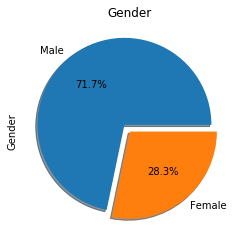

In [6]:
data["Gender"].value_counts().plot.pie(title="Gender", explode=(0.1, 0), labels=["Male", "Female"], autopct="%1.1f%%", shadow=True)

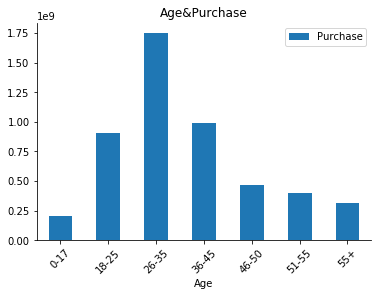

In [7]:
data.groupby(["Age"]).sum()[["Purchase"]].plot.bar(title="Age&Purchase")
plt.xticks(rotation=45)
sns.despine()

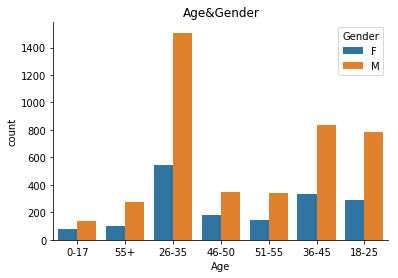

In [8]:
sns.countplot(data["Age"], hue=data["Gender"]).set_title("Age&Gender")
sns.despine()

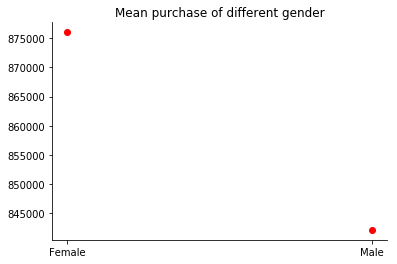

In [9]:
x = data.groupby(["Gender"]).mean()[["Purchase"]].index
y = data.groupby(["Gender"]).mean()[["Purchase"]].values
plt.plot(x, y,"ro")
plt.xticks(x, ["Female", "Male"])
plt.title("Mean purchase of different gender")
sns.despine()

From the age and gender figures, we can see several interesting things. First of all, the main customers for black friday sale are male(over 70 percent), especially those of age 26-35, who account for almost one third of male cuntomers of all ages. Secondly, the figure of mean purchase of different gender shows that individual female customer generally spend more(about $30k more) that their male counterpart. In spite of gender, people between age of 18 and 45 have made up almost four fifths(4 billion) of black friday sales. Young men showed greater purchasing power overall, but it's also possible that male customers are paying when shopping together with females.

### 2. city

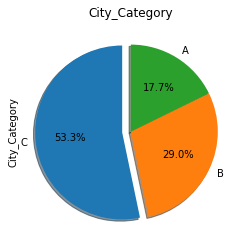

In [10]:
data["City_Category"].value_counts().plot.pie(title="City_Category", startangle=90, explode=(0.1, 0, 0), autopct="%1.1f%%", shadow=True)

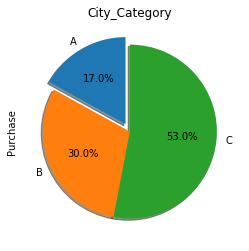

In [11]:
data.groupby("City_Category")["Purchase"].sum().plot.pie(title="City_Category", startangle=90, explode=(0.1, 0, 0), autopct="%1.1f%%", shadow=True)

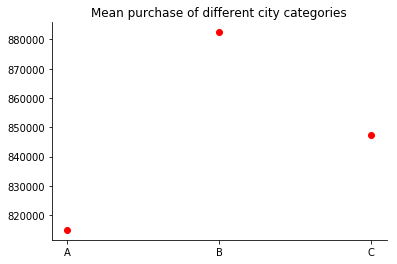

In [12]:
# data.groupby(["City_Category"]).mean()[["Purchase"]].plot.bar(title="Mean purchase of different city", figsize=(9, 6))
# sns.despine()
x = data.groupby(["City_Category"]).mean()[["Purchase"]].index
y = data.groupby(["City_Category"]).mean()[["Purchase"]].values
plt.plot(x, y,"ro")
plt.title("Mean purchase of different city categories")
sns.despine()

Customers from C_category cities make up more than half of our black  friday sales. Surprisingly, although there are not very many customers from B_type city, they relatively spend about $45K more than other customers in each  puachase. On the contrary, we didn't get very many customers from A_type city and they spent the least in our store. This should be noted when making future marketing plans. In later sections, we will explore more details about what they buy.

### 3. Occupation

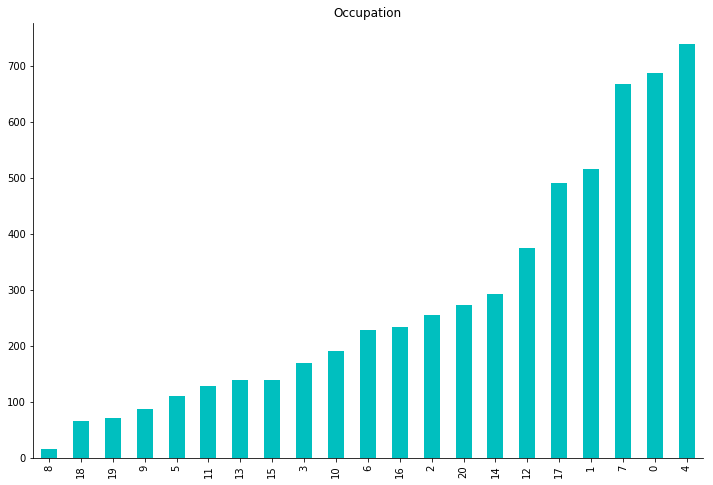

In [13]:
data["Occupation"].value_counts().sort_values().plot.bar(title="Occupation", color="c", figsize=(12, 8))
sns.despine()

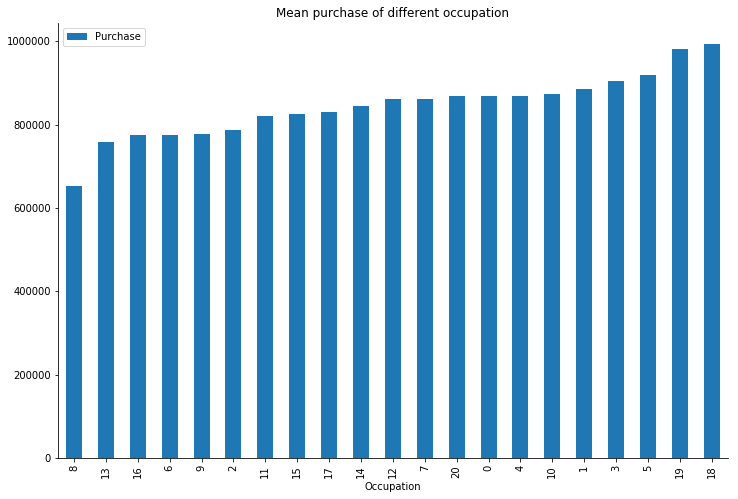

In [14]:
data.groupby(["Occupation"]).mean()[["Purchase"]].sort_values(by="Purchase").plot.bar(title="Mean purchase of different occupation", figsize=(12, 8))
sns.despine()

From occupation figure only we see that our customers have a wide range of occupations. Overall, the bars show a steep cliff. Ocupation 4, 0, 7, 1, 17, 1 are the most common ones and they exceed other occupations by a great margin, which means people having this six occupations should definately be our main marketing target. 
    The second figure above shows something very different. There is a cluster in how much they spent, most people spent around 600K to 800K in our store. People with occupation 18, 19 typically spent more than others in our store on Black Friday, although none of them were in the common occupations for our customers. As a matter of fact, occupation 18 and 19 were next to the least common occupation for our customers. Therefore we should make different marketing stratgies for our biggest target and biggest spender.

### 4. Residence Stability

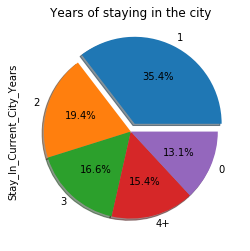

In [15]:
data["Stay_In_Current_City_Years"].value_counts().plot.pie(title="Years of staying in the city", explode=(0.1, 0, 0, 0, 0), autopct="%1.1f%%", shadow=True)

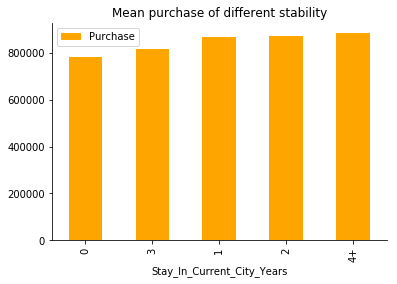

In [16]:
data.groupby(["Stay_In_Current_City_Years"]).mean()[["Purchase"]].sort_values(by="Purchase").plot.bar(title="Mean purchase of different stability", color="orange")
sns.despine()

New residents(one year or less) consist of around half of our black friday customers, which shows that we appear to be more popular for new comers. People who have been living in current city for longer spend a bit more than new comers. Since they chose to stay with us, we do need to find out what kept them loyal so we can make better plans to keep more customers instead of losing them over time.

### 5. Product

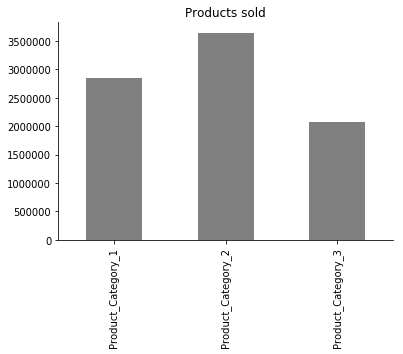

In [17]:
data.sum()[["Product_Category_1", "Product_Category_2", "Product_Category_3"]].plot.bar(title="Products sold", color="grey")
sns.despine()

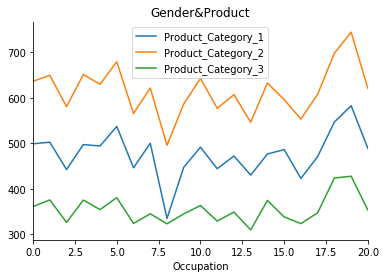

In [18]:
data.groupby(["Occupation"]).mean()[["Product_Category_1", "Product_Category_2", "Product_Category_3"]].plot.line(title="Gender&Product")
sns.despine()

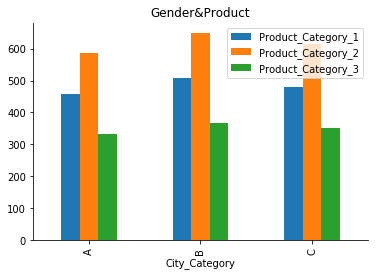

In [19]:
data.groupby(["City_Category"]).mean()[["Product_Category_1", "Product_Category_2", "Product_Category_3"]].plot.bar(title="Gender&Product")
sns.despine()

Products under category 2 are our most popular items, and this is true for all kinds of customers coming from different backgrounds. 

Above is some analysis about trends of our black friday sale as well as correlations between different demograghical features and purchase, these relationships can be valuable when trying to maximize profit. Now we will try to predict future sales with these data.

## Predict future sales(Purchase)

Text(0.5, 1.0, 'Correlation between features')

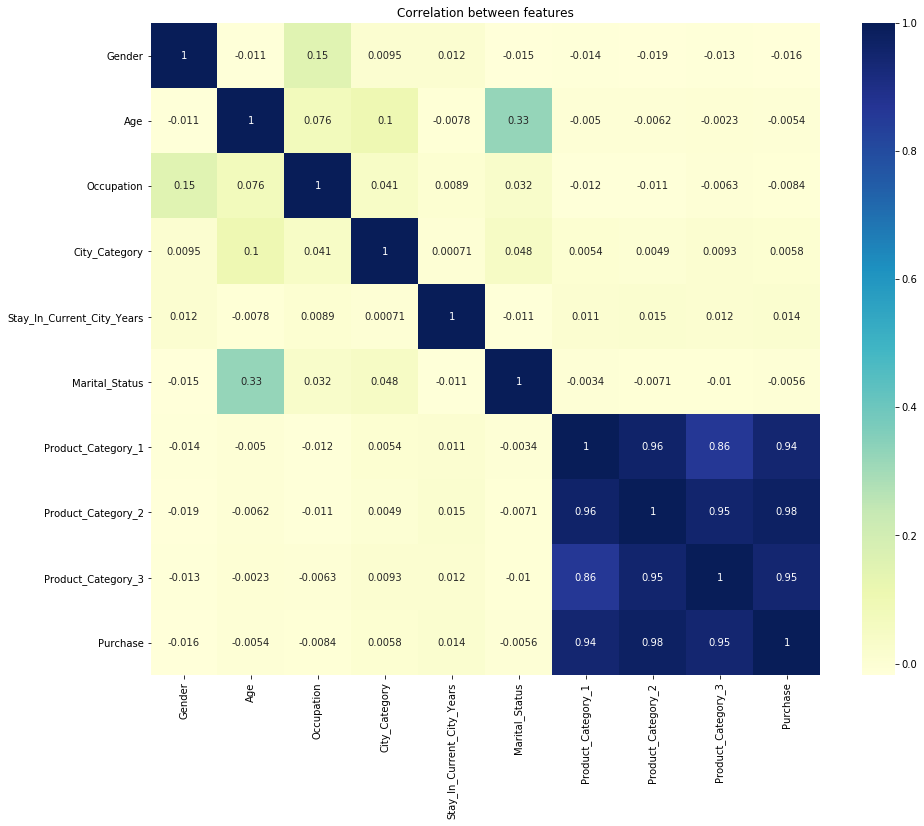

In [20]:
# label encoding: categorical to numeric
le = preprocessing.LabelEncoder()
cat_col = data.select_dtypes(include="object").columns.tolist()
for i in cat_col:
    data.loc[:, i] = le.fit_transform(data.loc[:, i])
    
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(data.drop("User_ID", axis=1).corr(), annot=True, cmap="YlGnBu").set_title("Correlation between features")

From the heatmap above we can observe there are strong correlations between different types' products and purchase. There is also some correlation between age and marital status which is in line with common sense. Unfortunately, there is no single feature that shows strong correlation with purchase directly, so we can understand this as that purchase depends on the ensemble of all features.

In [21]:
predictor = data.drop("Purchase", axis=1)
target = data["Purchase"]

# find the best parameter for model making
param_grid = {"n_estimators":[1, 5, 10, 50, 100, 150, 300, 500], \
              "max_depth":[1, 3, 5, 7, 9]}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring="neg_mean_squared_error").fit(predictor, target)
print("Best parameter: {}".format(grid_rf.best_params_))
print("Best score: {:.2f}".format((-1*grid_rf.best_score_)**0.5))

Best parameter: {'max_depth': 9, 'n_estimators': 150}
Best score: 193625.83


In [22]:
# make model with best parameters
model = RandomForestRegressor(n_estimators=500, max_depth=9, random_state=1, verbose=1)


# predict with cross validation
scores = cross_val_score(model, predictor, target, scoring="explained_variance", cv=5)
print(scores)
print("Model effectiveness: %f" % (scores.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[0.95295525 0.95990488 0.95791431 0.953862   0.95914217]
Model effectiveness: 0.956756


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
